In [19]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import RMSprop, adam
from keras.models import Model, Sequential
from keras.datasets import cifar10
from keras.layers.normalization import BatchNormalization
from keras import backend as K
# from keras.layers.noise import AlphaDropout

In [9]:
import keras
from keras.models import Sequential
from keras import layers
from keras.datasets import mnist
from keras import backend as K
# Alpha Dropout function 
'''
Got the code from Keras repository
'''
class AlphaDropout(layers.Layer):
    """Applies Alpha Dropout to the input.
    Alpha Dropout is a `Dropout` that keeps mean and variance of inputs
    to their original values, in order to ensure the self-normalizing property
    even after this dropout.
    Alpha Dropout fits well to Scaled Exponential Linear Units
    by randomly setting activations to the negative saturation value.
    # Arguments
        rate: float, drop probability (as with `Dropout`).
            The multiplicative noise will have
            standard deviation `sqrt(rate / (1 - rate))`.
        seed: A Python integer to use as random seed.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Self-Normalizing Neural Networks](https://arxiv.org/abs/1706.02515)
    """
    def __init__(self, rate, noise_shape=None, seed=None, **kwargs):
        super(AlphaDropout, self).__init__(**kwargs)
        self.rate = rate
        self.noise_shape = noise_shape
        self.seed = seed
        self.supports_masking = True

    def _get_noise_shape(self, inputs):
        return self.noise_shape if self.noise_shape else K.shape(inputs)

    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs(inputs=inputs, rate=self.rate, seed=self.seed):
                alpha = 1.6732632423543772848170429916717
                scale = 1.0507009873554804934193349852946
                alpha_p = -alpha * scale

                kept_idx = K.greater_equal(K.random_uniform(noise_shape, seed=seed), rate)
                kept_idx = K.cast(kept_idx, K.floatx())

                # Get affine transformation params
                a = ((1 - rate) * (1 + rate * alpha_p ** 2)) ** -0.5
                b = -a * alpha_p * rate

                # Apply mask
                x = inputs * kept_idx + alpha_p * (1 - kept_idx)

                # Do affine transformation
                return a * x + b

            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

    def get_config(self):
        config = {'rate': self.rate}
        base_config = super(AlphaDropout, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# function for creating model with all parameters


In [33]:
'''
Parameter List

'''

def create_network(n_dense=6,
                   dense_units=16,
                   activation='selu',
                   dropout=AlphaDropout,
                   dropout_rate=0.1,
                   kernel_initializer='lecun_normal',
                   optimizer='adam',
                   num_classes=10,
                   batch_norm=False,
                   input_shape=784):
    
    
    model = Sequential()
    model.add(Dense(dense_units, input_shape=(input_shape,),
                    kernel_initializer=kernel_initializer))
    model.add(Activation(activation))
    if(batch_norm):
            model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    model.add(dropout(dropout_rate))

    for i in range(n_dense - 1):
        model.add(Dense(dense_units, kernel_initializer=kernel_initializer))
        model.add(Activation(activation))
        if(batch_norm):
            model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
        model.add(dropout(dropout_rate))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model
        
    
    

In [34]:
# model 1 relu+BN
network1 = {
    'n_dense': 4,
    'dense_units': 100,
    'activation': 'relu',
    'dropout': Dropout,
    'dropout_rate': 0.2,
    'kernel_initializer': 'glorot_uniform',
    'optimizer': 'RMSprop',
    'batch_norm':True
}
model1 = create_network(**network1)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 100)               78500     
_________________________________________________________________
activation_15 (Activation)   (None, 100)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_16 (Activation)   (None, 100)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 100)               400       
__________

In [23]:
# create your own custom function and add it

from keras.utils.generic_utils import get_custom_objects
def custom_selu(x):
    """Scaled Exponential Linear Unit. (Klambauer et al., 2017)
    # Arguments
        x: A tensor or variable to compute the activation function for.
    # References
        - [Self-Normalizing Neural Networks](https://arxiv.org/abs/1706.02515)
    """
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * K.elu(x, alpha)
get_custom_objects().update({'custom_selu': Activation(custom_selu)})

In [35]:
network2 = {
    'n_dense': 4,
    'dense_units': 100,
    'activation': 'custom_selu',
    'dropout': AlphaDropout,
    'dropout_rate': 0.2,
    'kernel_initializer': 'glorot_uniform',
    'optimizer': 'RMSprop',
    
}
model2 = create_network(**network2)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
activation_20 (Activation)   (None, 100)               0         
_________________________________________________________________
alpha_dropout_5 (AlphaDropou (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_21 (Activation)   (None, 100)               0         
_________________________________________________________________
alpha_dropout_6 (AlphaDropou (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
__________

In [26]:
batch_size = 128
num_classes = 10
epochs = 40

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)




60000 train samples
10000 test samples

Building network 1...


In [37]:
print('\nBuilding network 1...')

model1 = create_network(num_classes=num_classes, **network1)
history_model1 = model1.fit(x_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.1)

score_model1 = model1.evaluate(x_test,
                               y_test,
                               batch_size=batch_size,
                               verbose=1)


print('\nBuilding network 2...')
model2 = create_network(num_classes=num_classes, **network2)

history_model2 = model2.fit(x_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.1)

score_model2 = model2.evaluate(x_test,
                               y_test,
                               batch_size=batch_size,
                               verbose=1)

print('\nNetwork 1 results')
print('Hyperparameters:', network1)
print('Test score:', score_model1[0])
print('Test accuracy:', score_model1[1])
print('Network 2 results')
print('Hyperparameters:', network2)
print('Test score:', score_model2[0])
print('Test accuracy:', score_model2[1])

plt.plot(range(epochs),
         history_model1.history['val_loss'],
         'g-',
         label='Network 1 Val Loss')
plt.plot(range(epochs),
         history_model2.history['val_loss'],
         'r-',
         label='Network 2 Val Loss')
plt.plot(range(epochs),
         history_model1.history['loss'],
         'g--',
         label='Network 1 Loss')
plt.plot(range(epochs),
         history_model2.history['loss'],
         'r--',
         label='Network 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('comparison_of_networks.png')


Building network 1...
Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - 2s - loss: 0.4702 - acc: 0.8543 - val_loss: 0.1300 - val_acc: 0.9592
Epoch 2/40
54000/54000 [==============================] - 2s - loss: 0.2192 - acc: 0.9349 - val_loss: 0.1023 - val_acc: 0.9695
Epoch 3/40
54000/54000 [==============================] - 2s - loss: 0.1751 - acc: 0.9490 - val_loss: 0.0912 - val_acc: 0.9735
Epoch 4/40
54000/54000 [==============================] - 3s - loss: 0.1467 - acc: 0.9569 - val_loss: 0.0858 - val_acc: 0.9765
Epoch 5/40
54000/54000 [==============================] - 3s - loss: 0.1348 - acc: 0.9607 - val_loss: 0.0882 - val_acc: 0.9738
Epoch 6/40
54000/54000 [==============================] - 3s - loss: 0.1196 - acc: 0.9637 - val_loss: 0.0817 - val_acc: 0.9763
Epoch 7/40
54000/54000 [==============================] - 3s - loss: 0.1097 - acc: 0.9676 - val_loss: 0.0708 - val_acc: 0.9803
Epoch 8/40
54000/54000 [===============

54000/54000 [==============================] - 3s - loss: 0.0912 - acc: 0.9733 - val_loss: 0.1547 - val_acc: 0.9802
Epoch 24/40
54000/54000 [==============================] - 3s - loss: 0.0901 - acc: 0.9735 - val_loss: 0.1478 - val_acc: 0.9810
Epoch 25/40
54000/54000 [==============================] - 3s - loss: 0.0859 - acc: 0.9754 - val_loss: 0.1494 - val_acc: 0.9800
Epoch 26/40
54000/54000 [==============================] - 3s - loss: 0.0891 - acc: 0.9741 - val_loss: 0.1374 - val_acc: 0.9798
Epoch 27/40
54000/54000 [==============================] - 3s - loss: 0.0856 - acc: 0.9751 - val_loss: 0.1520 - val_acc: 0.9807
Epoch 28/40
54000/54000 [==============================] - 3s - loss: 0.0794 - acc: 0.9774 - val_loss: 0.1717 - val_acc: 0.9778
Epoch 29/40
54000/54000 [==============================] - 3s - loss: 0.0807 - acc: 0.9766 - val_loss: 0.1425 - val_acc: 0.9807
Epoch 30/40
54000/54000 [==============================] - 2s - loss: 0.0769 - acc: 0.9769 - val_loss: 0.1333 - val_

NameError: name 'plt' is not defined

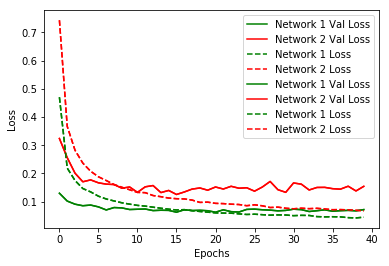

In [39]:
from matplotlib import pyplot as plt
plt.plot(range(epochs),
         history_model1.history['val_loss'],
         'g-',
         label='Network 1 Val Loss')
plt.plot(range(epochs),
         history_model2.history['val_loss'],
         'r-',
         label='Network 2 Val Loss')
plt.plot(range(epochs),
         history_model1.history['loss'],
         'g--',
         label='Network 1 Loss')
plt.plot(range(epochs),
         history_model2.history['loss'],
         'r--',
         label='Network 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('comparison_of_networks.png')

In [40]:
network3 = {
    'n_dense': 4,
    'dense_units': 100,
    'activation': 'relu',
    'dropout': Dropout,
    'dropout_rate': 0.2,
    'kernel_initializer': 'glorot_uniform',
    'optimizer': 'RMSprop',
    
}
model3 = create_network(**network3)
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 100)               78500     
_________________________________________________________________
activation_35 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_36 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 100)               10100     
__________

In [41]:
print('\nBuilding network 2...')
#model2 = create_network(num_classes=num_classes, **network2)

history_model3 = model3.fit(x_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.1)

score_model3 = model3.evaluate(x_test,
                               y_test,
                               batch_size=batch_size,
                               verbose=1)



Building network 2...
Train on 54000 samples, validate on 6000 samples
Epoch 1/40
54000/54000 [==============================] - 2s - loss: 0.5351 - acc: 0.8349 - val_loss: 0.1535 - val_acc: 0.9552
Epoch 2/40
54000/54000 [==============================] - 2s - loss: 0.2455 - acc: 0.9299 - val_loss: 0.1219 - val_acc: 0.9648
Epoch 3/40
54000/54000 [==============================] - 2s - loss: 0.1905 - acc: 0.9469 - val_loss: 0.1080 - val_acc: 0.9692
Epoch 4/40
54000/54000 [==============================] - 2s - loss: 0.1619 - acc: 0.9538 - val_loss: 0.1083 - val_acc: 0.9695
Epoch 5/40
54000/54000 [==============================] - 2s - loss: 0.1464 - acc: 0.9591 - val_loss: 0.0858 - val_acc: 0.9765
Epoch 6/40
54000/54000 [==============================] - 2s - loss: 0.1306 - acc: 0.9628 - val_loss: 0.0897 - val_acc: 0.9755
Epoch 7/40
54000/54000 [==============================] - 2s - loss: 0.1240 - acc: 0.9664 - val_loss: 0.0913 - val_acc: 0.9762
Epoch 8/40
54000/54000 [===============

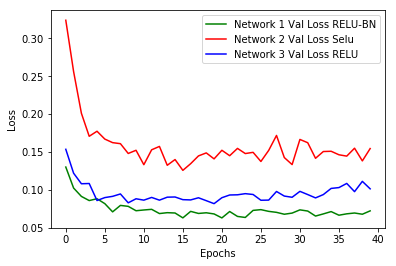

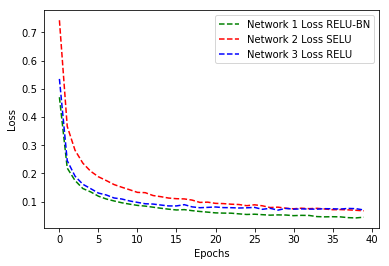

In [43]:
plt.figure()
plt.plot(range(epochs),
         history_model1.history['val_loss'],
         'g-',
         label='Network 1 Val Loss RELU-BN')
plt.plot(range(epochs),
         history_model2.history['val_loss'],
         'r-',
         label='Network 2 Val Loss Selu')
plt.plot(range(epochs),
         history_model3.history['val_loss'],
         'b-',
         label='Network 3 Val Loss RELU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(epochs),
         history_model1.history['loss'],
         'g--',
         label='Network 1 Loss RELU-BN')
plt.plot(range(epochs),
         history_model2.history['loss'],
         'r--',
         label='Network 2 Loss SELU')
plt.plot(range(epochs),
         history_model3.history['loss'],
         'b--',
         label='Network 3 Loss RELU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('comparison_of_networks.png')